# Analysis of TargetScan relationships
Océane Carpentier

In [1]:
library(ggplot2)
library(data.table)
library(tidyr)
library(dplyr)
theme_set(theme_bw(base_size = 16))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Nombre de relations Targetscan :

Par type de relation :
```cypher
MATCH (m:miRNA)-[r:TARGETS]->(g:Gene)
WITH m, g,r
RETURN r.type AS Type, count(*) AS nbRelations;
```

| Type    | nbRelations |
|-----------|-----------|
| "6mer"    | 5893195   |
| "8mer-1a" | 847695    |
| "7mer-1a" | 2177191   |
| "7mer-m8" | 2277859   |


## Nombre de couples miARN-gène :

Au total :
```cypher
MATCH (m:miRNA)-[r:TARGETS]->(g:Gene)
WITH DISTINCT m, g
RETURN count(*) AS nbCouples;
```

| nbCouples |
|-----------|
| 3216561   |

</pre>

Par type de relation :
```cypher
MATCH (m:miRNA)-[r:TARGETS]->(g:Gene)
WITH DISTINCT m, g, r.type AS Type
RETURN Type, count(*) AS nbCouples;
```

| Type      | nbCouples |
|-----------|-----------|
| "6mer"    | 2253259   |
| "8mer-1a" | 510057    |
| "7mer-1a" | 1135502   |
| "7mer-m8" | 1159167   |


In [2]:
setwd("/home/ocarpentier")

In [3]:
rel_targetscan <- data.table::fread(file = "work/result/aggregation/targetscan_gene_mirdeep_known_filtered.csv",col.names = c("TargetGene","RegulatoryGene","Type","Start","End"), sep=",",data.table=FALSE)

In [4]:
head(rel_targetscan)

TargetGene       RegulatoryGene Type    Start End  
1 LOC_000000000000 mirdeep2.1014  8mer-1a  4643  4650
2 LOC_000000000000 mirdeep2.1014  8mer-1a  2050  2057
3 LOC_000000000000 mirdeep2.1014  8mer-1a  4717  4724
4 LOC_000000000000 mirdeep2.1014  8mer-1a  4542  4549
5 LOC_000000000000 mirdeep2.1014  8mer-1a   333   340
6 LOC_000000000000 mirdeep2.1014  8mer-1a 14388 14395

## Nombre de relations Targetscan pour un couple miARN-gène

In [5]:
count_type_summary <- rel_targetscan %>% group_by(TargetGene, RegulatoryGene, Type) %>% summarise(Count = n())

`summarise()` has grouped output by 'TargetGene', 'RegulatoryGene'. You can override using the
`.groups` argument.


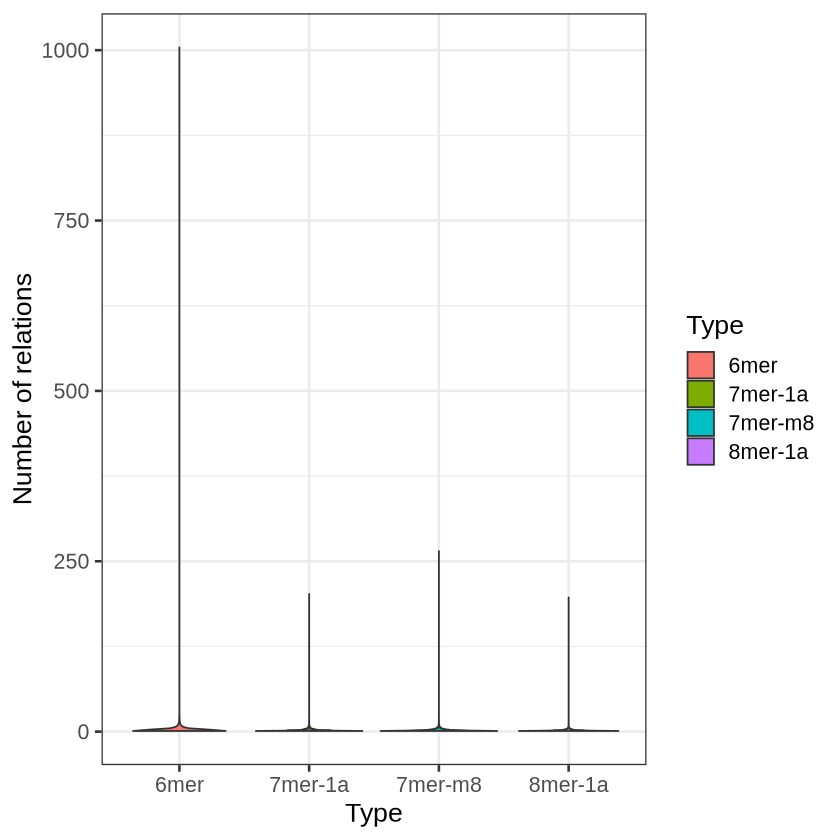

In [6]:
ggplot(count_type_summary, aes(x = Type, y = Count, fill = Type)) +
  geom_violin() +
  labs(tx = "Type of site",
       y = "Number of relations")

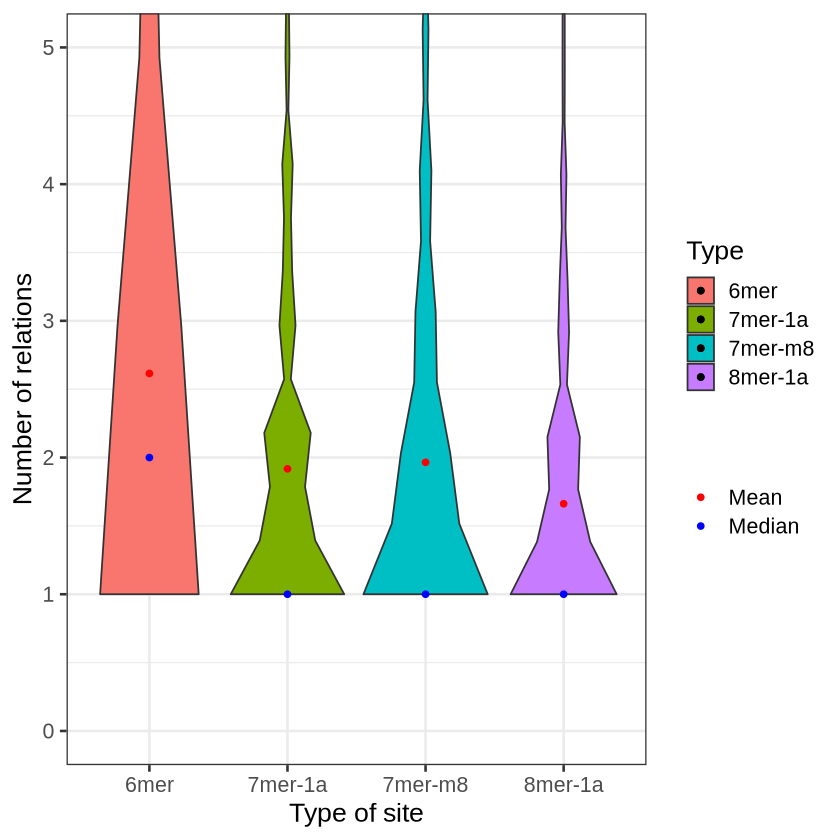

In [7]:
ggplot(count_type_summary, aes(x = Type, y = Count, fill = Type)) +
  geom_violin() + 
  labs(x = "Type of site",
       y = "Number of relations") + coord_cartesian(ylim = c(0,5)) +
stat_summary(fun = "mean",geom = "point", aes(color = "Mean")) +
stat_summary(fun = "median",geom = "point",aes(color = "Median")) +
scale_colour_manual(values = c("red", "blue"), name = "")

## Nombre de gènes régulés par un même miARN :

Commande cypher :
```cypher
MATCH (m:miRNA)-[r:TARGETS]->(g:Gene)
WITH m, count(DISTINCT g) AS nbGene
RETURN avg(nbGene) AS Gene_regulated_sameMiRNA;
```

In [8]:
count_target_summary <- rel_targetscan %>% group_by(RegulatoryGene) %>% summarise(NbTarget = n_distinct(TargetGene))

In [9]:
head(count_target_summary)

RegulatoryGene NbTarget
1 mirdeep2.1014  12283   
2 mirdeep2.1021   7151   
3 mirdeep2.1037   2893   
4 mirdeep2.1038   2893   
5 mirdeep2.1040   7151   
6 mirdeep2.1056  12247

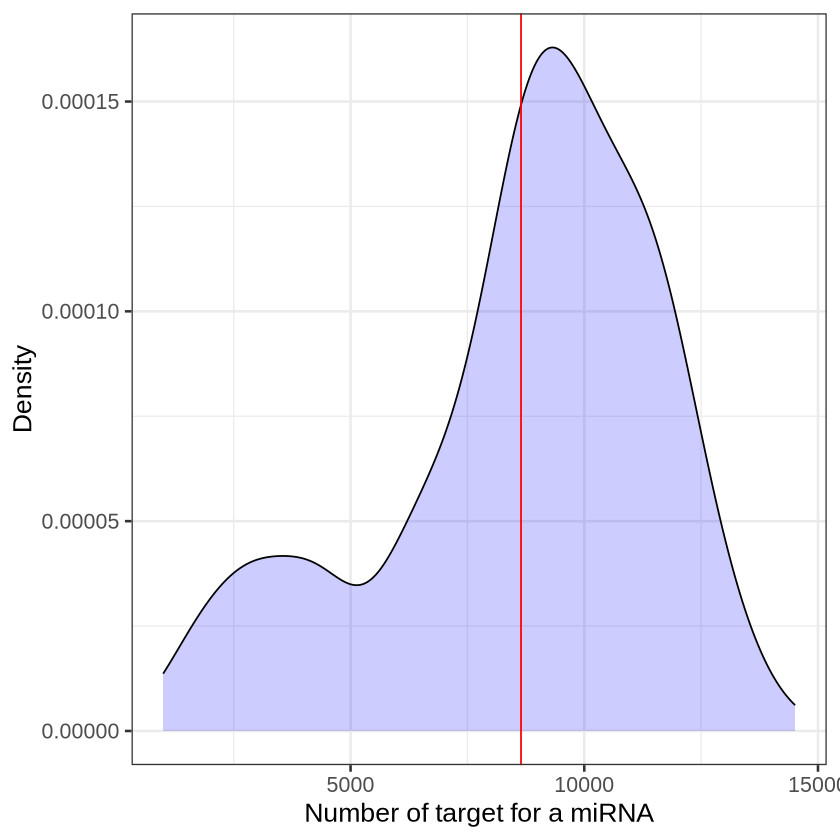

In [10]:
ggplot()+ geom_density(data=count_target_summary,aes(x=NbTarget,y = after_stat(density)),alpha=.2, fill = "blue") + 
geom_vline(xintercept=mean(count_target_summary$NbTarget), colour="red")+labs(x = "Number of target for a miRNA",
       y = "Density")

Nombre de gènes régulés par un même miARN en fonction du biotype du type de site :

In [11]:
count_target_type_summary <- rel_targetscan %>% group_by(RegulatoryGene,Type) %>% summarise(NbTarget = n_distinct(TargetGene))

`summarise()` has grouped output by 'RegulatoryGene'. You can override using the `.groups` argument.


In [12]:
head(count_target_type_summary)

RegulatoryGene Type    NbTarget
1 mirdeep2.1014  6mer    9200    
2 mirdeep2.1014  7mer-1a 4349    
3 mirdeep2.1014  7mer-m8 6164    
4 mirdeep2.1014  8mer-1a 2243    
5 mirdeep2.1021  6mer    4601    
6 mirdeep2.1021  7mer-1a 2618

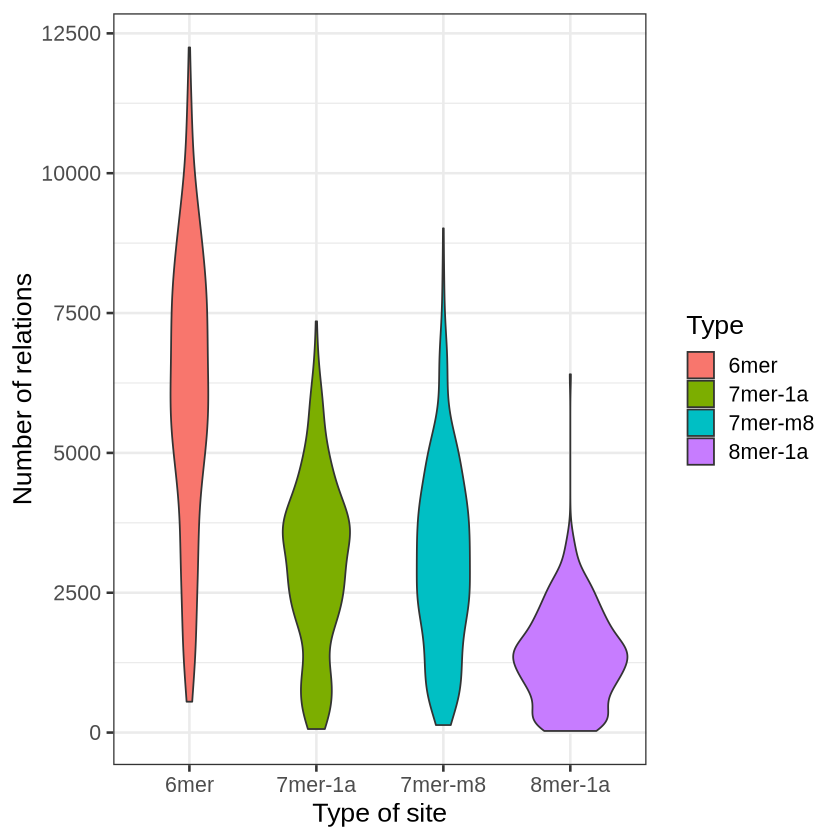

In [14]:
ggplot(count_target_type_summary, aes(x = Type, y = NbTarget, fill = Type)) +
  geom_violin() + 
  labs(x = "Type of site",
       y = "Number of relations")

## Nombre de miARN régulant un même gène :

Commande cypher :

```cypher
MATCH (m:miRNA)-[r:TARGETS]->(g:Gene)
WITH g, count(DISTINCT m) AS nbMiRNA
RETURN avg(nbMiRNA) AS MiRNA_regulating_sameGene;
```

In [15]:
count_regulator_summary <- rel_targetscan %>% group_by(TargetGene) %>% summarise(NbRegulator = n_distinct(RegulatoryGene))

In [16]:
head(count_regulator_summary)

TargetGene       NbRegulator
1 LOC_000000000000 332        
2 LOC_000000000001  15        
3 LOC_000000000004 274        
4 LOC_000000000005 200        
5 LOC_000000000006 224        
6 LOC_000000000007 329

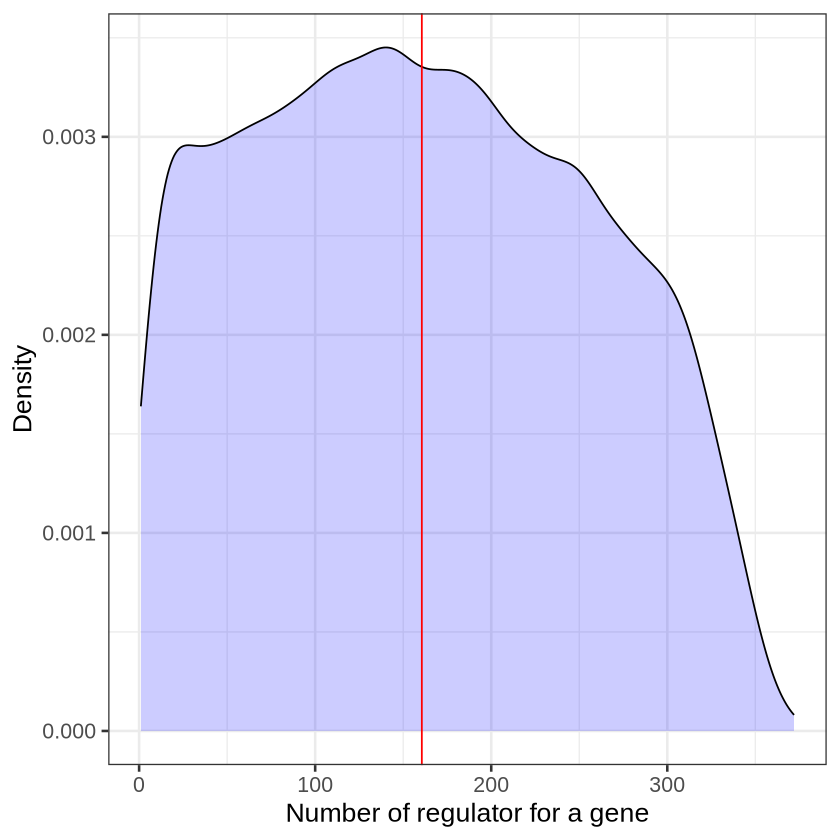

In [17]:
ggplot()+ geom_density(data=count_regulator_summary,aes(x=NbRegulator,y = after_stat(density)),alpha=.2, fill = "blue") + 
geom_vline(xintercept=mean(count_regulator_summary$NbRegulator), colour="red")+labs(x = "Number of regulator for a gene",
       y = "Density")

Nombre de miARN régulant un même gène en fonction du type de site :

In [18]:
count_regulator_type_summary <- rel_targetscan %>% group_by(TargetGene,Type) %>% summarise(NbRegulator = n_distinct(RegulatoryGene))

`summarise()` has grouped output by 'TargetGene'. You can override using the `.groups` argument.


In [19]:
head(count_regulator_type_summary)

TargetGene       Type    NbRegulator
1 LOC_000000000000 6mer    306        
2 LOC_000000000000 7mer-1a 239        
3 LOC_000000000000 7mer-m8 223        
4 LOC_000000000000 8mer-1a 133        
5 LOC_000000000001 6mer      7        
6 LOC_000000000001 7mer-1a   3

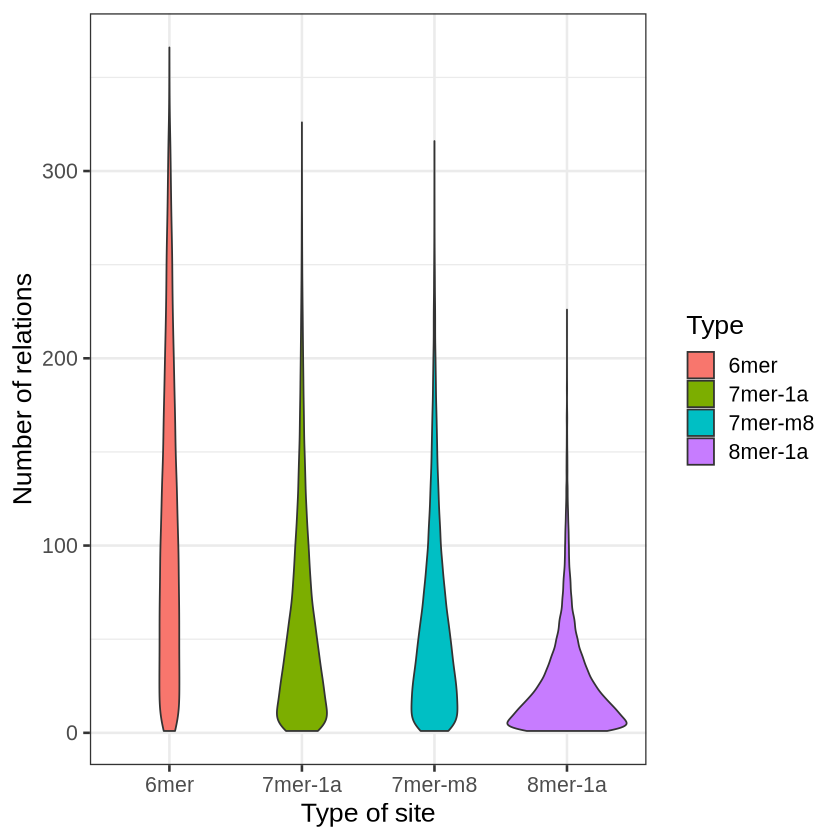

In [20]:
ggplot(count_regulator_type_summary, aes(x = Type, y = NbRegulator, fill = Type)) +
  geom_violin() + 
  labs(x = "Type of site",
       y = "Number of relations")

## Biotype des gènes cibles :

Run this lines before continue :
```bash
dir=/home/ocarpentier/work/result/cypher
cypher-shell -u neo4j -p multireg "MATCH (m:miRNA)-[r:TARGETS]->(g:Gene) RETURN g.name AS Gene, m.name AS miRNA , r.type AS Type ,g.biotype AS Biotype" > $dir/biotype_target_targetscan.csv
``` 

In [21]:
biotype_target_targetscan = data.table::fread(file="/home/ocarpentier/work/result/cypher/biotype_target_targetscan.csv",sep=",", data.table=FALSE)

In [22]:
head(biotype_target_targetscan)

Gene             miRNA       Type    Biotype
1 LOC_000000220922 mirdeep2.12 6mer    lncRNA 
2 LOC_000000220922 mirdeep2.12 6mer    lncRNA 
3 LOC_000000220423 mirdeep2.12 8mer-1a lncRNA 
4 LOC_000000220229 mirdeep2.12 6mer    lncRNA 
5 LOC_000000219670 mirdeep2.12 7mer-1a lncRNA 
6 LOC_000000219670 mirdeep2.12 7mer-m8 lncRNA

In [23]:
type_biotype_totals <- biotype_target_targetscan %>% group_by(Type, Biotype) %>% summarise(Total = n())

`summarise()` has grouped output by 'Type'. You can override using the `.groups` argument.


In [24]:
print(type_biotype_totals)

# A tibble: 12 × 3
# Groups:   Type [4]
   Type    Biotype   Total
   <chr>   <chr>     <int>
 1 6mer    TUCp      14637
 2 6mer    lncRNA  1127547
 3 6mer    mRNA    4751011
 4 7mer-1a TUCp       5341
 5 7mer-1a lncRNA   424530
 6 7mer-1a mRNA    1747320
 7 7mer-m8 TUCp       5654
 8 7mer-m8 lncRNA   441594
 9 7mer-m8 mRNA    1830611
10 8mer-1a TUCp       2044
11 8mer-1a lncRNA   166560
12 8mer-1a mRNA     679091


In [25]:
type_biotype_uniq_totals <- unique(biotype_target_targetscan) %>% group_by(Type, Biotype) %>% summarise(Total = n()) # sans doublons

`summarise()` has grouped output by 'Type'. You can override using the `.groups` argument.


In [26]:
print(type_biotype_uniq_totals)

# A tibble: 12 × 3
# Groups:   Type [4]
   Type    Biotype   Total
   <chr>   <chr>     <int>
 1 6mer    TUCp      10892
 2 6mer    lncRNA   501870
 3 6mer    mRNA    1740497
 4 7mer-1a TUCp       4588
 5 7mer-1a lncRNA   248135
 6 7mer-1a mRNA     882779
 7 7mer-m8 TUCp       4767
 8 7mer-m8 lncRNA   253061
 9 7mer-m8 mRNA     901339
10 8mer-1a TUCp       1856
11 8mer-1a lncRNA   110786
12 8mer-1a mRNA     397415


In [27]:
type_biotype_percentages <- type_biotype_totals %>% group_by(Type) %>% mutate(Percentage = (Total / sum(Total)) * 100)

In [28]:
print(type_biotype_percentages)

# A tibble: 12 × 4
# Groups:   Type [4]
   Type    Biotype   Total Percentage
   <chr>   <chr>     <int>      <dbl>
 1 6mer    TUCp      14637      0.248
 2 6mer    lncRNA  1127547     19.1  
 3 6mer    mRNA    4751011     80.6  
 4 7mer-1a TUCp       5341      0.245
 5 7mer-1a lncRNA   424530     19.5  
 6 7mer-1a mRNA    1747320     80.3  
 7 7mer-m8 TUCp       5654      0.248
 8 7mer-m8 lncRNA   441594     19.4  
 9 7mer-m8 mRNA    1830611     80.4  
10 8mer-1a TUCp       2044      0.241
11 8mer-1a lncRNA   166560     19.6  
12 8mer-1a mRNA     679091     80.1  


In [29]:
type_biotype_uniq_percentages <- type_biotype_uniq_totals %>% group_by(Type) %>% mutate(Percentage = (Total / sum(Total)) * 100) # sans doublons

In [30]:
print(type_biotype_uniq_percentages)

# A tibble: 12 × 4
# Groups:   Type [4]
   Type    Biotype   Total Percentage
   <chr>   <chr>     <int>      <dbl>
 1 6mer    TUCp      10892      0.483
 2 6mer    lncRNA   501870     22.3  
 3 6mer    mRNA    1740497     77.2  
 4 7mer-1a TUCp       4588      0.404
 5 7mer-1a lncRNA   248135     21.9  
 6 7mer-1a mRNA     882779     77.7  
 7 7mer-m8 TUCp       4767      0.411
 8 7mer-m8 lncRNA   253061     21.8  
 9 7mer-m8 mRNA     901339     77.8  
10 8mer-1a TUCp       1856      0.364
11 8mer-1a lncRNA   110786     21.7  
12 8mer-1a mRNA     397415     77.9  


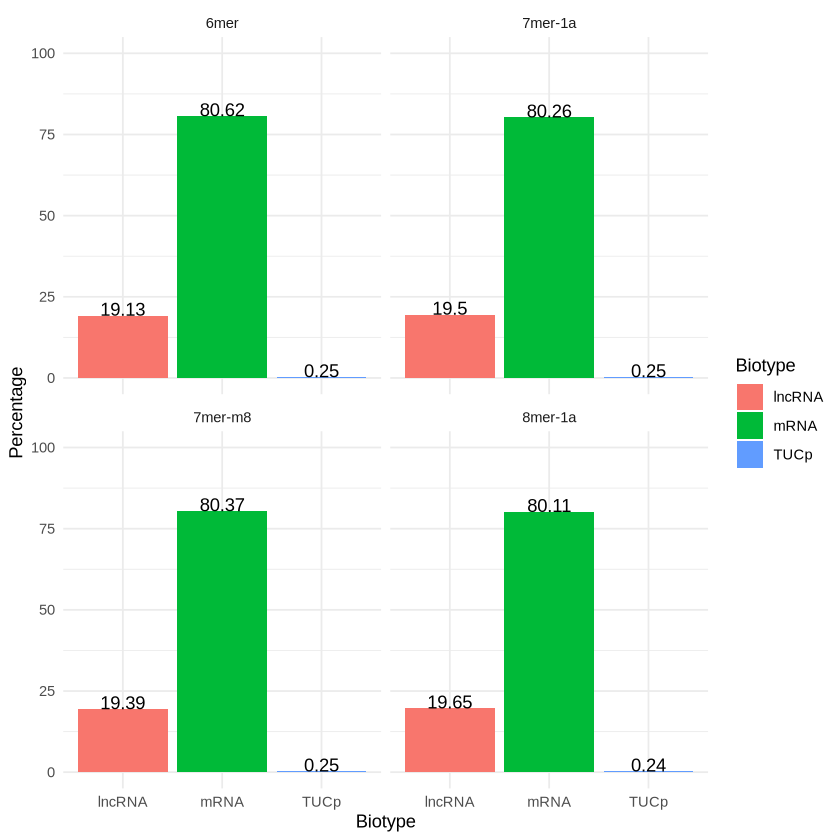

In [31]:
ggplot(type_biotype_percentages, aes(x = Biotype, y=Percentage,fill=Biotype)) +
  geom_bar(stat='identity') +
  facet_wrap(~ Type) + 
  labs(x = "Biotype",
       y = "Percentage") + 
  theme_minimal() + 
  geom_text(aes(label = round(Percentage, 2)), position = position_dodge(width = 1), 
            vjust = "bottom", hjust = "center") +
  ylim(0,100)


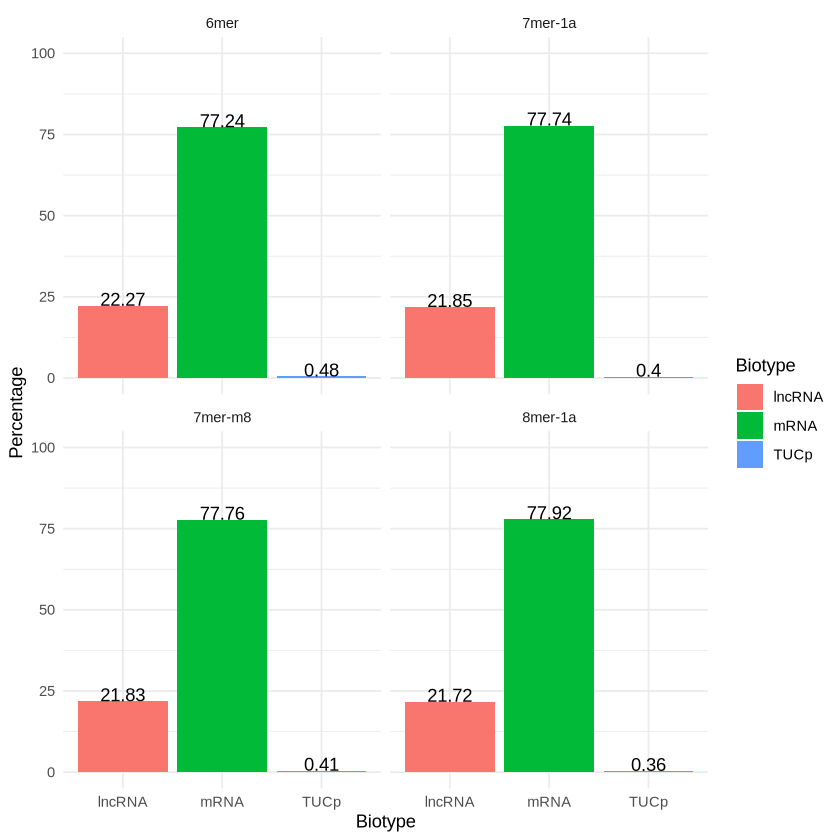

In [32]:
ggplot(type_biotype_uniq_percentages, aes(x = Biotype, y=Percentage,fill=Biotype)) +
  geom_bar(stat='identity') +
  facet_wrap(~ Type) + 
  labs(x = "Biotype",
       y = "Percentage") + 
  theme_minimal() + 
  geom_text(aes(label = round(Percentage, 2)), position = position_dodge(width = 1), 
            vjust = "bottom", hjust = "center") +
  ylim(0,100)